# Sprint 2

We will start by loading in all the images

In [2]:
import os
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image

IMG_HEIGHT = 128
IMG_WIDTH = 128
img_folder = "./tripadvisor_dataset/tripadvisor_images"

def create_dataset(img_folder, n=None):
    wrong_data = 0
    img_data_array = []
    files = os.listdir(os.path.join(img_folder))

    if n is None:
        n = len(files)
    
    counter = 0
    for file in files:
        #print(file)
        if counter == n:
            break
        try:
            image_path = os.path.join(img_folder, file)
            image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)[..., ::-1] # convert BRG to RGB
            image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
            image = np.array(image).flatten()
            if len(image) == IMG_HEIGHT*IMG_WIDTH*3:
                image = image.astype('float32')
                image /= 255
                img_data_array.append(image)
            else:
                wrong_data += 1

        except Exception as e:
            print("file", file, "could not process:", e)
        counter += 1
    
    print("There are", wrong_data, "images that are too small.")

    return np.array(img_data_array)





In [4]:

images = create_dataset(img_folder,230)


# import tensorflow as tf
# data_dir ='tripadvisor_dataset/tripadvisor_images/' 
# image = train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#   data_dir,
#   validation_split=0.2,
#   subset="training",
#   seed=123,
#   image_size=(128, 128))

There are 1 images that are too small.


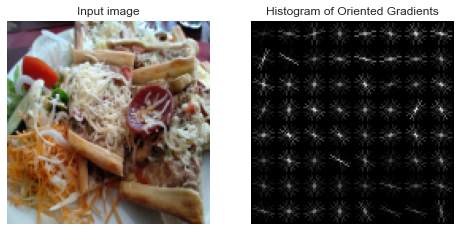

In [23]:
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt

# plt.imshow(images[0].reshape((128,128,3)))
img = images[0].reshape(IMG_HEIGHT,IMG_WIDTH,3)

fd, hog_image = hog(img,orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, channel_axis=-1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(img, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [24]:
images_hogs = np.zeros((images.shape[0], 512 * 3))

for i, img in tqdm(enumerate(images), total=len(images)):
    img = img.reshape((128,128,3))
    for channel in range(3):
        fd = hog(img[:,:,channel], orientations=8, pixels_per_cell=(16, 16),
                cells_per_block=(1, 1), visualize=False, feature_vector=True)
        images_hogs[i, channel*512:channel*512+512] = fd


100%|██████████| 25/25 [00:00<00:00, 72.07it/s]


In [25]:
images_hogs

array([[0.40597931, 0.17340122, 0.43869033, ..., 0.27691481, 0.50615233,
        0.50615233],
       [0.48363426, 0.30857196, 0.22845609, ..., 0.28633887, 0.35412157,
        0.36971495],
       [0.91431987, 0.00625244, 0.01802353, ..., 0.43177226, 0.43177226,
        0.43177226],
       ...,
       [0.35867575, 0.11807612, 0.23720565, ..., 0.06321379, 0.54914618,
        0.54914618],
       [0.69084996, 0.02511472, 0.03048484, ..., 0.38383657, 0.38383657,
        0.38383657],
       [0.45191541, 0.14996098, 0.13129136, ..., 0.36313927, 0.36887199,
        0.36887199]])

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
from yellowbrick.cluster import silhouette_visualizer
from sklearn.cluster import KMeans

# scale hog features
sc = StandardScaler()
hogs_scaled = sc.fit_transform(images_hogs)

kpca = KernelPCA(n_components=90, kernel='cosine')
transformed = kpca.fit_transform(hogs_scaled)



In [27]:
kmeans2 = KMeans(n_clusters=20, random_state=0)
predictions = kmeans2.fit_predict(transformed)

# silhouette_visualizer(kmeans2, transformed)

CLUSTER 0


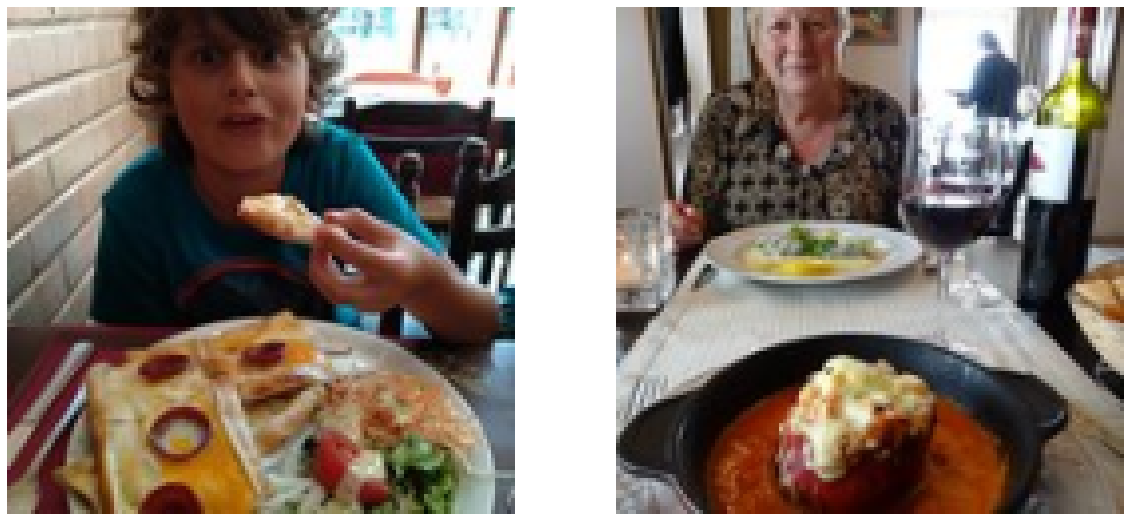

CLUSTER 1


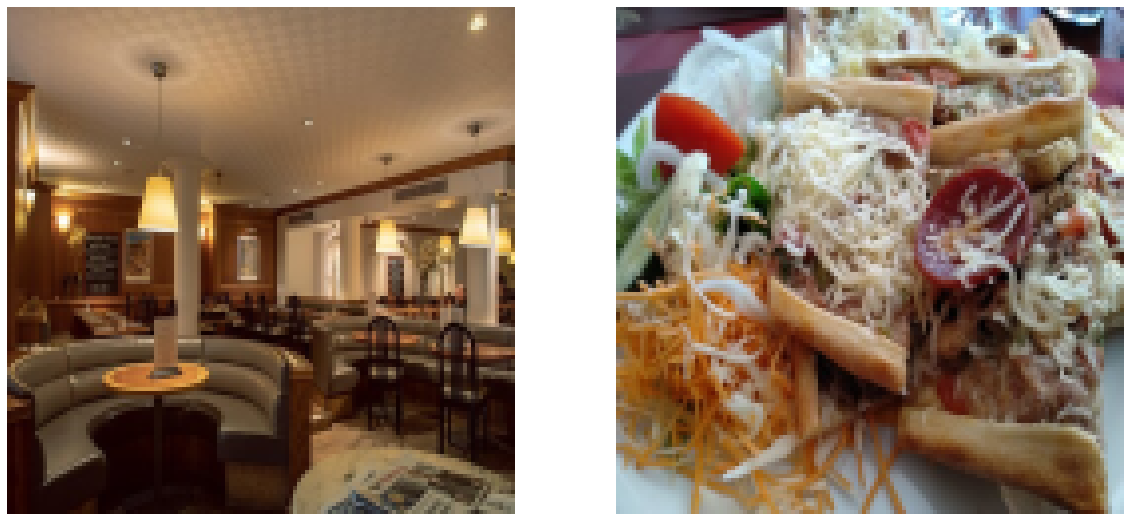

In [31]:
# you can optionally give this function the distances of the instances to the cluster centers (obtainable by using the models transform function)
def show_predictions(predictions, n_clusters, images, distances=None):
    for cluster in range(n_clusters):
        print(f"CLUSTER {cluster}")

        cluster_images = images[np.where(predictions == cluster)]

        if distances is not None:
            # we sort the images so that they are displayed in order of distance to cluster center
            cluster_distances=  np.min(distances[np.where(predictions == cluster)], axis=1)
            cluster_instances_sorted = np.argsort(cluster_distances)
            cluster_images = cluster_images[cluster_instances_sorted[::-1]]
                
        num_pics = 10 if cluster_images.shape[0] > 10 else cluster_images.shape[0]

        # try to pick out images closes to the cluster centers
        if num_pics == 0:
            print("No images in this cluster")
            continue
        if num_pics == 1:
            plt.figure()
            plt.imshow(cluster_images[0].reshape((128,128,3)))
            plt.axis("off")
            plt.show()
            continue
        indices = np.random.choice(np.arange(cluster_images.shape[0]), num_pics, replace=False)
        _, axs = plt.subplots(1, num_pics, figsize=(20,20))
        axs = axs.flatten()
        for img, ax in zip(cluster_images[indices], axs):
            ax.imshow(img.reshape((128,128,3)))
            ax.set_axis_off()
        plt.show()

show_predictions(predictions, 2, images)

## SURF

In [29]:
# import cv2
# image = cv2.imread(r'tripadvisor_dataset/tripadvisor_images/694642_0.jpg', cv2.COLOR_BGR2RGB)[..., ::-1] # convert BRG to RGB
# # sift = cv2.xfeatures2d.SIFT_create()
# surf = cv2.xfeatures2d.SURF_create()
# image


Image


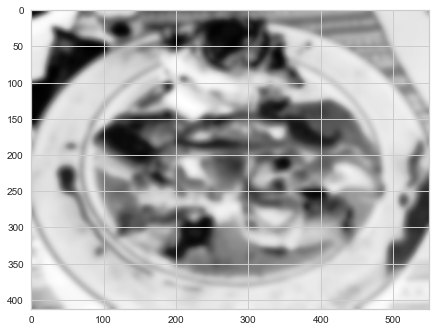

No of  points: 316


(316, 70)

In [42]:
import mahotas
import mahotas.demos
import mahotas as mh
import numpy as np
from pylab import imshow, show
from mahotas.features import surf
import cv2
 
# loading image
image = cv2.imread(r'tripadvisor_dataset/tripadvisor_images/694642_0.jpg', cv2.COLOR_BGR2RGB)[..., ::-1]

# removing color
nuclear = image[:, :, 0]
 
# adding gaussian filter
nuclear = mahotas.gaussian_filter(nuclear, 4)
 
# showing image
print("Image")
# imshow(image)
imshow(nuclear)

show()
 
 
# getting Speeded-Up Robust Features
spoints = surf.surf(nuclear)
print("No of  points: {}".format(len(spoints)))
spoints.shape

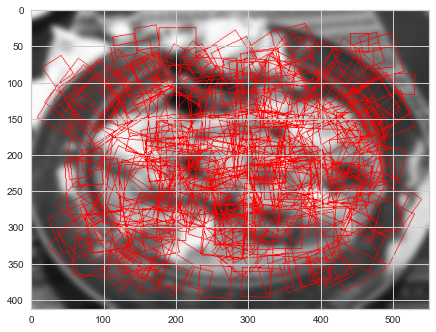

In [44]:
f2 = surf.show_surf(nuclear, spoints)
imshow(f2)

In [54]:
descrs = spoints[:,5:]
descrs

array([[-6.81544293e-02, -2.70098801e-03, -4.04479730e-03, ...,
         6.76838827e-03,  3.45942610e-03,  6.87935334e-03],
       [ 8.52558173e-01, -1.86376353e-03,  2.71579987e-04, ...,
        -8.44426238e-03,  3.72934355e-03,  8.81986722e-03],
       [-4.08073071e-02, -1.53807184e-03,  4.69340749e-04, ...,
         2.67600569e-03,  1.29519685e-02,  1.16461087e-02],
       ...,
       [-1.08154917e+00, -1.99051028e-03, -2.45797054e-03, ...,
         5.15807409e-02,  1.97307078e-02,  5.15807409e-02],
       [-2.66805772e+00, -1.27394332e-03, -1.19801443e-03, ...,
        -8.06954759e-03,  2.52451035e-03,  8.06954759e-03],
       [ 2.24367622e+00,  7.89519269e-04,  5.56314620e-03, ...,
         1.10827850e-02,  2.91387475e-03,  1.10827850e-02]])

Dense Image


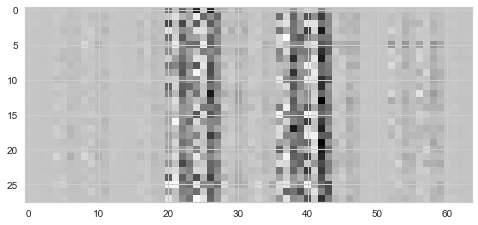

In [60]:
dense_img = surf.dense(nuclear, 50)
 
# showing image
print("Dense Image")
imshow(dense_img)
show()